<a href="https://colab.research.google.com/github/naznmr/Patient-Data/blob/main/real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import random
import pickle
import math
import missingno as msno
from multiprocessing.dummy import Pool as ThreadPool
import time
import sys
import csv
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as func
import sklearn.metrics as metrics
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy.interpolate import interp1d
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import requests
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
import ssl
import urllib.request

# تنظیم SSL context برای غیرفعال کردن چک کردن گواهی
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
# download data
import os
import urllib.request
urllib.request.urlretrieve('https://archive.physionet.org/users/shared/challenge-2019/training_setA.zip','training_setA.zip')
# unzip
!unzip -q training_setA.zip
# delete zip file
!rm training_setA.zip
!mv training training_setA

In [ ]:
data_path = "training_setA"
patient_ids = sorted(os.listdir(data_path))
data = [] # list of df for each patient

for i in tqdm(range(len(patient_ids))):
    file_path = os.path.join(data_path, patient_ids[i])
    if os.path.isfile(file_path):  # فقط فایل‌ها را پردازش کنید
        df = pd.read_csv(file_path, sep="|")
        df['PatientID'] = patient_ids[i]
        data.append(df)

100%|██████████| 20337/20337 [01:31<00:00, 221.95it/s]


1 - 1

این کد درصد بیمارانی که دچار سپسیس هستند رو محاسبه میکنه با شمارش تعداد بیماران مبتلا به سپسیس تقسیم بر تعداد کل بیماران و درنهایت ضرب در 100 می کنیم.

In [ ]:
sepsis = "SepsisLabel" # تعریف متغییر که نام ستون مربوط به SepsisLabel را در خود ذخیره میکند.
sepsis_count = 0 # متغییری برای شمارش تعداد بیماران مبتلا به سپسیس که مقدار اولیه اش برابر با 0 است.
total_records = 0 # متغییری برای شمارش کل رکوردها که همان تعداد همه بیماران می باشد و مقدار اولیه اش برابر با 0 است.

for i in data: # یک حلقه برای تکرار روی هر data.
    if sepsis in i.columns: # بررسی میکنه که آیا ستون SepsisLabel موجود است یا نه.
        # اگر موجود باشد دوخط بعدی اجرا می شوند.
        sepsis_count += i[sepsis].sum() # تعداد بیماران مبتلا به سپسیس را به مجموع sepsis_count اضافه میکند.
        total_records += len(i) # تعداد کل بیماران را به مجموع total_records اضافه میکند.

if total_records > 0: # بررسی میکند که آیا تعداد بیماران بیشتر از 0 است یا نه
  # اگر تعداد بیماران بیشتر از 0 باشد خط بعدی اجرا میشود.
  sepsis_percent = (sepsis_count / total_records) * 100 # تعداد بیماران مبتلا به سپسیس را بر تعداد کل بیماران تقسیم میکند و در نهایت پاسخ را در 100 ضرب میکند تا درصد بیماران مبتلا به سپسیس را محاسبه کند.
else:
  # اگر تعداد کل بیماران از 0 بیشتر نباشد خط بعدی اجرا میشود.
  sepsis_percent = 0 # درصد بیماران مبتلا به سپسیس را برابر با 0ئ قرار میدهد.

print("percent of sepsis patient = ", sepsis_percent) # چاپ نتیجه

percent of sepsis patient =  2.168523756192935


1 - 2

تعداد مردان و زنان را بر اساس ستون Gender از مجموعه داده ها محاسبه میکند و سپس میانگین و میانه سن هارا از ستون Age محاسبه می کند.

In [ ]:
gender = "Gender" # متغییری برا ذخیره ستون Gender یا جنسیت.
male_count = 0 # متغییری برای شمارش تعداد مردان که مقدار اولیه اش برابر با 0 است.
female_count = 0 # متغییری برای شمارش تعداد زنان که مقدار اولیه اش برابر با 0 است.

for i in data: # حلقه برای پیمایش در data.
  male_sum = (i[gender] == 0).sum() # تعداد مردان را محاسبه میکند و مقدار 0 را به مردان نسبت داده است.
  female_sum = (i[gender] == 1).sum() # تعداد زنان را محاسبه می کند و مقدار 1 را به زنان نسبت داده است.
  male_count += male_sum # تعداد مردان را به کل تعدادشان اضافه میکند.
  female_count += female_sum # تعداد زنان را به کل تعدادشان اضافه میکند.

print("Female count = ", female_count) # تعداد زنان را چاپ میکند.
print("Male count = ", male_count) # تعداد مردان را چاپ میکند.

age = "Age" # متغییری برای ذخیره ستون Age یا سن.
combined_data = pd.concat(data, ignore_index = True) # همه داده ها به یک DataFrame ترکیب میشوند.

mean_age = combined_data[age].mean() # میانگین سن هارا محاسبه میکند.
median_age = combined_data[age].median() # میانه همه سن هارا محاسبه میکند.

print("mean = ", mean_age) # میانگین سن را چاپ میکند.
print("median = ", median_age) # میانه سن را چاپ میکند.

Female count =  456524
Male count =  333691
mean =  63.01677985105323
median =  65.25


1 - 3

این کد طول هر داده در data را محاسبه میکند و یک هیستوگرام از ساعات رسم میکند تا توزیع تعداد بیماران نشان داده شود.

length of patients = 
 [54, 23, 48, 29, 48, 17, 45, 40, 258, 23, 34, 21, 39, 42, 15, 19, 37, 134, 48, 19, 57, 19, 21, 51, 50, 13, 10, 31, 48, 45, 55, 51, 37, 13, 41, 16, 18, 38, 45, 24, 34, 73, 45, 34, 19, 50, 18, 16, 18, 50, 40, 43, 25, 57, 14, 9, 35, 8, 37, 9, 18, 41, 14, 28, 29, 19, 18, 46, 12, 36, 54, 20, 23, 13, 38, 50, 23, 104, 42, 37, 36, 44, 50, 42, 55, 20, 46, 15, 26, 41, 54, 32, 29, 37, 35, 19, 34, 54, 22, 38, 36, 46, 19, 41, 37, 59, 40, 48, 48, 40, 49, 37, 21, 29, 56, 22, 48, 19, 17, 40, 45, 39, 49, 24, 41, 10, 49, 23, 26, 48, 46, 56, 56, 38, 17, 30, 40, 38, 42, 29, 61, 49, 53, 51, 26, 22, 44, 58, 25, 23, 24, 42, 22, 29, 34, 36, 42, 40, 37, 53, 23, 53, 35, 44, 39, 29, 19, 30, 53, 52, 69, 22, 24, 24, 20, 28, 24, 97, 50, 40, 24, 43, 36, 39, 65, 47, 44, 84, 57, 53, 37, 31, 40, 19, 31, 20, 42, 16, 37, 43, 47, 58, 81, 20, 41, 23, 59, 20, 44, 19, 8, 43, 55, 38, 38, 40, 35, 45, 48, 54, 54, 47, 43, 39, 40, 18, 37, 53, 27, 54, 34, 22, 22, 25, 38, 24, 31, 19, 19, 23, 20, 40, 46, 26, 5

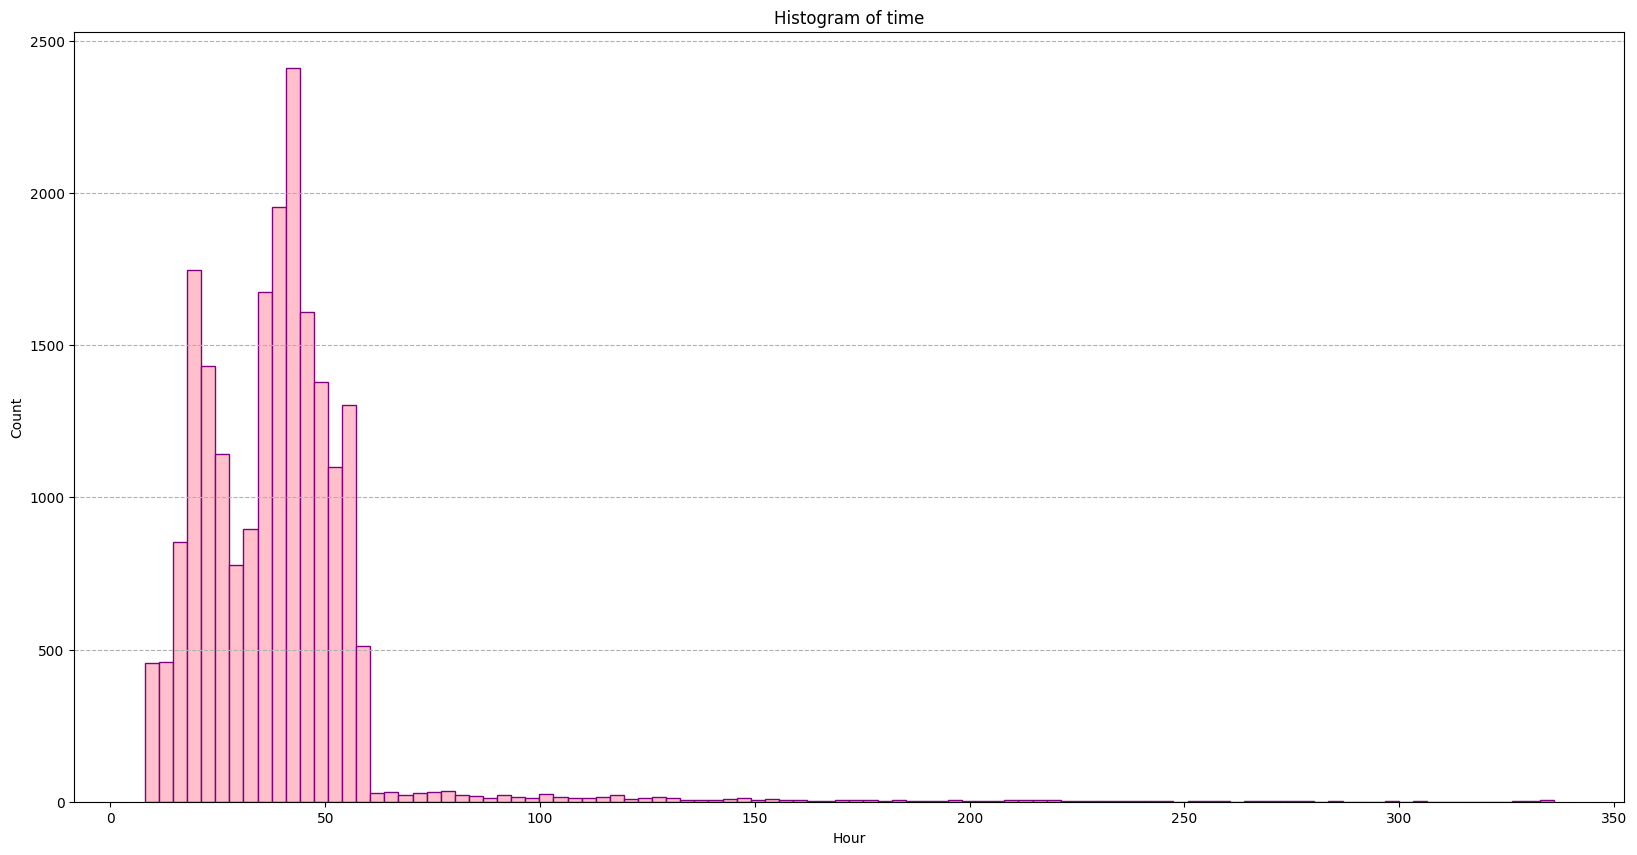

In [ ]:
patient_length = [] # تعریف یک لیست خالی برای ذخیره طول داده ها.

for i in data: # حلقه برای پیمایش در data
  len_i = len(i) # محاسبه تعداد بیماران درهر رکورد
  patient_length.append(len_i) # طول محاسبه شده را به لیست تعریف شده اضافه میکند.

print("length of patients = \n", patient_length) # لیست طول های بیماران را چاپ میکند.
print("\n") # به سطر بعدی می رود.

plt.figure(figsize = (20, 10)) # تنظیم اندازه نمودار هیستوگرام.
plt.hist(patient_length, bins = 100, color = "pink", edgecolor = "purple") # هیستوگرام به داده های طول بیماران تنظیم میشود که داده ها به 100 باین مختلف تقسیم میشوند و رنگ حاشیه نمودار بنفش و رنگ نمودار صورتی است.
plt.title("Histogram of time") # تعریف عنوان نمودار هیستوگرام
plt.xlabel("Hour") # تعریف برچسب محورافقی
plt.ylabel("Count") # تعریف برچسب محور عمودی
plt.grid(axis = "y", linestyle = "--") # برای محور عمودی یا همان محور y ها خطوط -- رسم میشود.
plt.show() # نمایش نمودار

1 - 4

این کد زمان اولین بستری بیماران مبتلا به سپسیس را استخراج کرده و یک هیستوگرام از این زمان ها رسم میکند تا توزیع زمان های بستری را نشان دهد.

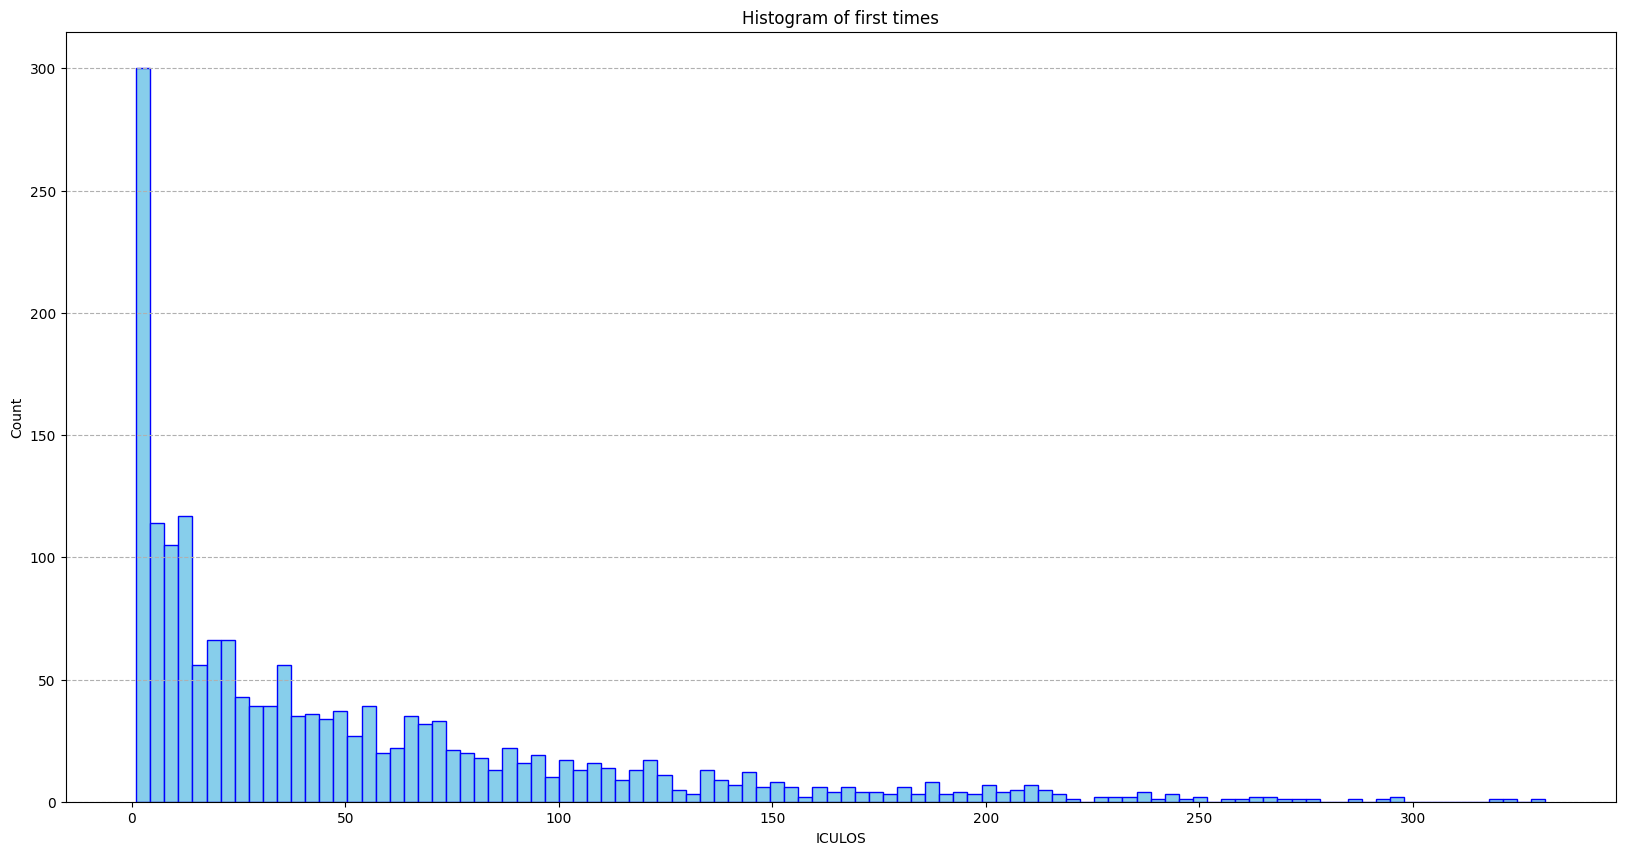

In [ ]:
sepsis = "SepsisLabel" # تعریف یک متغییر برای نگه داشتن نام ستون SepsisLabel.
sepsis_time = "ICULOS" # تعریف یک متغییر برای نگه داشتن نام ستون ICULos.
sepsis_times = [] # تعریف لیست خالی برای ذخیره زمان های بستری بیماران مبتلا به سپسیس.

for i in data: # حلقه برای پیمایش در data.
    if (sepsis in i.columns) and (sepsis_time in i.columns): # بررسی میکند که آیا ستون های sepsis و sepsis_time موجود هستند یا نه.
        # اگر هردو ستون موجود باشند خطوط بعدی اجرا میشوند
        sepsis_rows = i[i[sepsis] == 1] # هرکجا مقدار ستون sepsis برابر با 1 باشد یعنی فرد بیمار مبتلا به سپسیس است و مبتلایان را در متغییری ذخیره میکنیم.
        if not sepsis_rows.empty: # بررسی میشود که آیا بیماران مبتلا به سپسیس وجود دارند و خالی نمیباشد.
            # اگر بیماران مبتلا به سپسیس وجود داشتند خط بعدی اجرا میشود.
            sepsis_times.append(sepsis_rows[sepsis_time].iloc[0]) # زمان اولین بستری یعنی مقدار ستون ICULos به لیست اضافه میشود.


plt.figure(figsize = (20, 10)) # تنظیم اندازه نمودار هیستوگرام.
plt.hist(sepsis_times, bins = 100, color = "skyblue", edgecolor = "blue") # هیستوگرام به داده های طول بیماران تنظیم میشود که داده ها به 100 باین مختلف تقسیم میشوند و رنگ حاشیه نمودار آبی و رنگ نمودار آبی آسمانی است.
plt.title("Histogram of first times") # تعریف عنوان نمودار هیستوگرام
plt.xlabel("ICULOS") # تعریف برچسب محورافقی
plt.ylabel("Count") # تعریف برچسب محور عمودی
plt.grid(axis = "y", linestyle = "--") # برای محور عمودی یا همان محور y ها خطوط -- رسم میشود.
plt.show() # نمایش نمودار

1 - 5

این کد مقدار داده های گم شده در هر ویژگی از data را محاسبه میکند و 5 ویژگی با بیشترین داده گم شده را رسم میکند.

Top 5 missing data : 

EtCO2: 1.0
TroponinI: 0.9987788133609208
Bilirubin_direct: 0.9985042045519258
Fibrinogen: 0.9923691653537329
Bilirubin_total: 0.9877337180387616


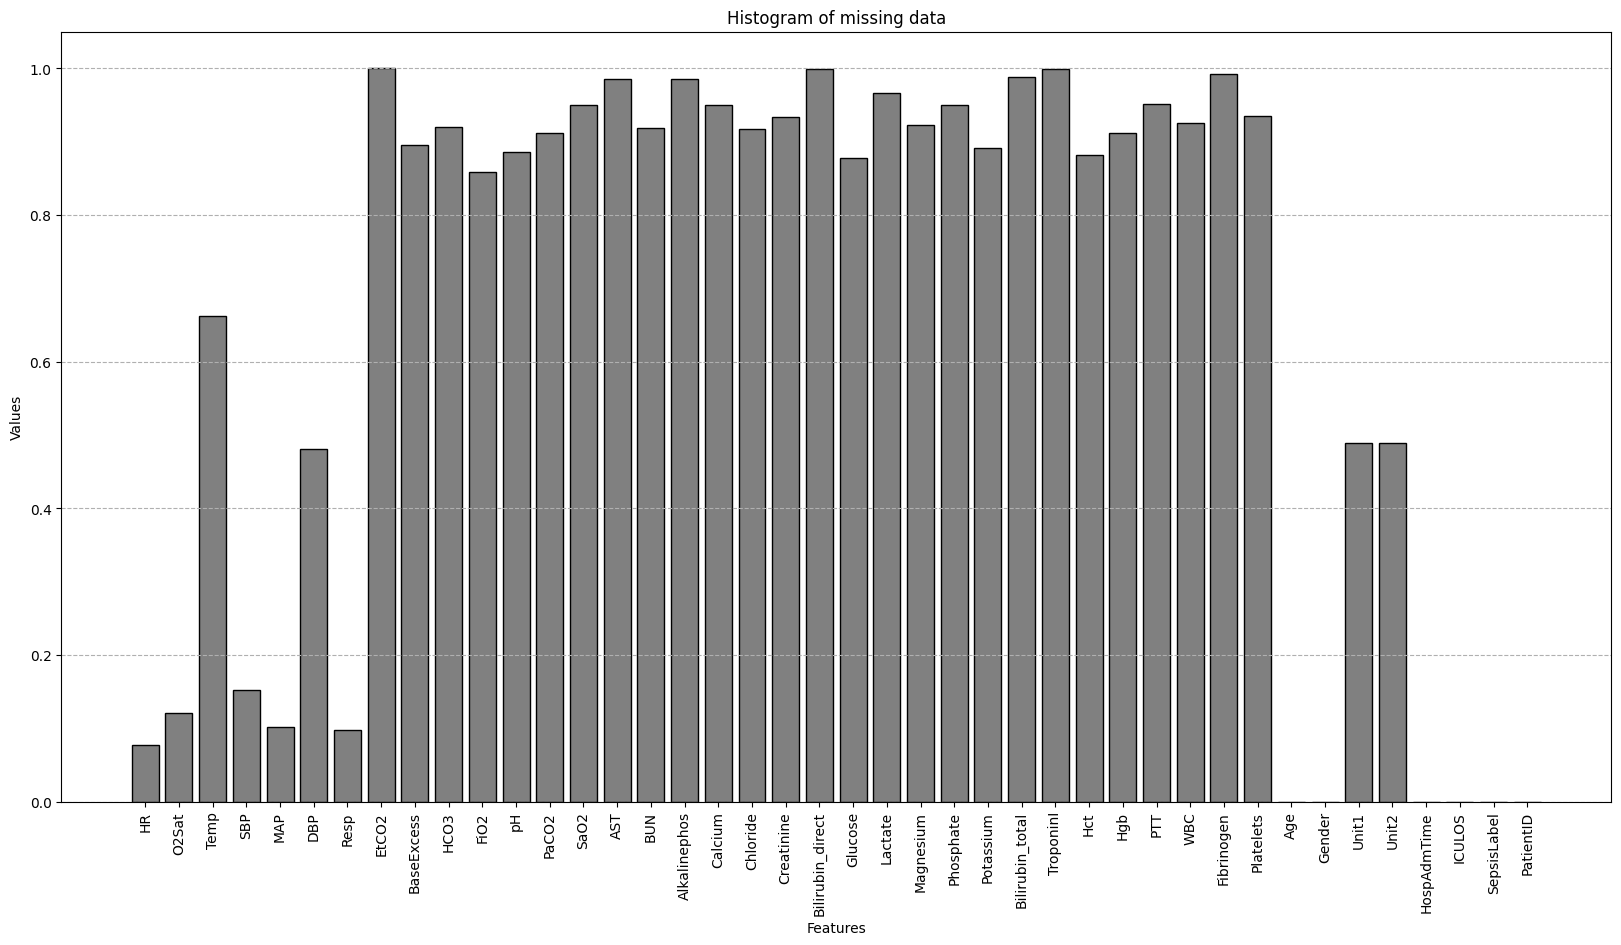

In [ ]:
missing_data = {} # یک دیکشنری خالی برای ذخیره مقادیر گم شده در هر ستون تعریف میکنیم.
total_rows = 0 # متغییری برای ذخیره کل ردیف ها یا بیماران

for i in data: # حلقه برای پیمایش در data.
    total_rows += len(i) # تعداد هر ردیف یا بیماران به کل ردیف ها اضافه میشود.
    for k in i.columns: # حلقه برای پیمایش در ستون ها
        if k not in missing_data: # بررسی میکند که آیا ستون فعلی قبلا در دیکشنری وجودد دارد یا نه.
            # اگر وجود نداشته باشد خط بعدی اجرا میشوند.
            missing_data[k] = 0 # مقدار ستون k در دیکشنری برابر با 0 قرار میگیرد.
        missing_data[k] += i[k].isna().sum() # تعداد مقادیر گم شده در هر ستون به تعداد کل مقادیر گم شده آن ستون اضافه میشود.

missing = {} # تعریف دیکشنری خالی برای ذخیره مقدار مقادیر گم شده.

for j in missing_data: # ایجاد حلقه برای پیمایش در کلیدهای دیکشنری missing_data.
    cal = missing_data[j] / total_rows # تعداد مقادیر گم شده را بر کل مقادیر تقسیم کرده و در متغییری ذخیره میشود.
    missing[j] = cal # مقدار محاسبه شده در خط قبلی به دیکشنری missing اضافه میشود.

sorted_missing = sorted(missing.items(), key=lambda x: x[1], reverse = True) # دیکشنری موردنظر بر اساس مقدار مقادیر گم شده از بیشترین مقدار به کمترین مقدار یعنی نزولی مرتب میشود.

top_5_missing = sorted_missing[:5] # 5 ویژگی با بیشترین مقادیر گم شده را در متغییری ذخیره میکند.

print("Top 5 missing data : \n") # پیامی را چاپ میکند.

for m, n in top_5_missing: # یک حلقه برای چاپ نام و مقدار مقادیر گم شده 5 ویژگی با بیشترین مقادیر گم شده ایجاد میشود.
    print(f"{m}: {n}") # نام ویژگی و مقدار مقادیر گم شده را چاپ میکند.

features = list(missing.keys()) # نام ویژگی هارا از دیکشنری استخراج کرده و به لیست تبدیل میکند و درنهایت در متغییری ذخیره میکند.
values = list(missing.values()) # مقدار مقادیر گم شده را از دیکشنری استخراج کرده و به لیست تبدیل میکند و درنهایت در متغییری ذخیره میکند.

plt.figure(figsize = (20, 10)) # تنظیم اندازه نمودار هیستوگرام.
plt.bar(features, values, color = "gray", edgecolor = "black") # هیستوگرام به داده های طول بیماران تنظیم میشود که داده ها به 100 باین مختلف تقسیم میشوند و رنگ حاشیه نمودار مشکی و رنگ نمودار خاکستری است.
plt.title("Histogram of missing data") # تعریف عنوان نمودار هیستوگرام
plt.xlabel("Features") # تعریف برچسب محورافقی
plt.ylabel("Values") # تعریف برچسب محور عمودی
plt.xticks(rotation = 90) # برچسب های محور افقیبه صورت 90 درجه چرخانده میشوند برای دیده شدن بهتر.
plt.grid(axis = "y", linestyle = "--") # برای محور عمودی یا همان محور y ها خطوط -- رسم میشود.
plt.show() # نمایش نمودار

2 - 1

این کد داده های گم شده در یک دیتاست ترکیب شده را بررسی کرده و ستون هایی که بیش از 50% مقادیر گم شده دارند را حذف میکند و سپس مقادیر گم شده را در ستون های عددی را با میانگین آن ستون پر میکند.

In [ ]:
combined_data = pd.concat(data, ignore_index = True) # داده ها را به یک DataFrame واحد تبدیل میکند و ایندکس ها به طور مجدد شماره گذاری میشوند و در متغییری ذخیره میشود.

missing_data = combined_data.isna().mean() # میانگین مقادیر مفقود شده در هر ستون را محاسبه میکند و در متغییری ذخیره میکند.
missing_percent = missing_data * 100 # درصد مقادیر گم شده را محاسبه میکند و در متغییری ذخیره میکند.

print("Percent of missing data : \n") # پیامی را چاپ میکند.
print(missing_percent) # درصد مقادیر مفقود شده در هر ستون راچاپ میکند.
print("\n") # به خط بعدی میرود.

missing_threshold = 50 # آستانه 50% برای حذف ویژگی ها تعریف میشود.
features_to_drop = missing_percent[missing_percent > missing_threshold].index # ویژگی هایی که بیشتر از 50% داده مفقود دارند را ایندکس میکند.

print("Droped Features : ", len(features_to_drop), " Features will drop. \n") # تعداد ویژگی های حذف شده را چاپ میکند.
print(features_to_drop.tolist()) # ویژگی هایی که باید حذف بشوند را به صورت لیست چاپ میکند.

X = combined_data.drop(columns = features_to_drop) # ویژگی های تشخیص داده شده برای حذف، حذف میشوند و داده ها با ویژگی های حذف شده در متغییری ذخیره میشوند.

numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns # نام ستون های عددی استخراج میشوند.
non_numeric_columns = X.select_dtypes(exclude=['float64', 'int64']).columns # نام ستون های غیر عددی استخراج میشوند.

X[numeric_columns] = X[numeric_columns].fillna(X[numeric_columns].mean()) # درستون های عددی مقادیر مفقود شده با میانگین آن ستون جایگزین میشود.

print("All datas : \n") # پیامی را چاپ میکند.
print(X) # داده های نهایی را چاپ میکند.

Percent of missing data : 

HR                    7.743336
O2Sat                12.032042
Temp                 66.224255
SBP                  15.211177
MAP                  10.232405
DBP                  48.125763
Resp                  9.776833
EtCO2               100.000000
BaseExcess           89.574863
HCO3                 91.949406
FiO2                 85.807027
pH                   88.532868
PaCO2                91.231753
SaO2                 95.044387
AST                  98.504205
BUN                  91.840702
Alkalinephos         98.540650
Calcium              95.024392
Chloride             91.676063
Creatinine           93.357884
Bilirubin_direct     99.850420
Glucose              87.768392
Lactate              96.565112
Magnesium            92.219712
Phosphate            94.951247
Potassium            89.137640
Bilirubin_total      98.773372
TroponinI            99.877881
Hct                  88.223711
Hgb                  91.164303
PTT                  95.152459
WBC        

2 - 2

این کد برای پیشبینی برچسب SepsisLabel از داده های مربوط به بیماران از یک مدل LSTM استفاده میکند. ابتدا داده هارا پیش پردازش کرده ویژگی های خلاصه برای هر بیمار استخراج میشود و سپس با استفاده از داده های پیش پردازش شده مدل آموزش میبیند.

In [ ]:
id = "PatientID" # متغییری برای ذخیره ستون id بیماران
sepsis = "SepsisLabel" # متغییری برای ذخیره ستون SepsisLabel
summary_features = [] # لیست خالی برای ذخیره ویژگی های خلاصه شده برای هر بیمار

features_to_drop = [col for col in features_to_drop if col != id] # ستون مربوط به آیدی بیماران از لیست ویژگی ها حذف نمیشود.
X = combined_data.drop(columns=features_to_drop) # ستون های غیرضروری را حذف میکند.

for patient_id, group in X.groupby(id): # داده ها بر اساس آیدی بیماران گروه بندی میشوند.
    if group[sepsis].max() == 1: # بررسی میکند که آیا مقدار ستون sepsis برابر با 1 است یا نه که اگر برابر با 1 بود یعنی بیمار مبتلا به سپسی میباشد.
        # اگر بیمار مبتلا به سپسیس بود خطوط بعدی اجرا میشوند.
        sepsis_time = group[group[sepsis] == 1].index[0] # زمان اولین وقوع سپسیس برای بیمار مشخص میشود  و در متغییری ذخیره میشود.
        relevant_data = group.loc[:sepsis_time - 3] # داده های مربوط به بیمار تا 3 ساعت قبل از تشخیص استخراج میشود و در متغییری ذخیره میشود.
    else:
        # اگر بیمار به سپسیس مبتلا نباشد خط بعدی اجرا میشود.
        relevant_data = group.head(20) # 20 رکورد اول داده ها انتخاب میشود.

    summary = { # تعریف دیکشنری ای از ویژگی های خلاصه شده
        "PatientID" : patient_id, # ذخیره آیدی بیمار
        "Mean_HR" : relevant_data["HR"].mean(), # ذخیره میانگین ضربان قلب بیمار
        "Min_HR" : relevant_data["HR"].min(), # ذخیره کمترین ضربان قلب بیمار
        "Max_HR" : relevant_data["HR"].max(), # ذخیره بیشترین ضربان قلب بیمار
    }
    summary_features.append(summary) # ویژگی های خلاصه برای هر بیمار به لیست اضافه میشوند.

summary_df = pd.DataFrame(summary_features) # لیست ویژگی های خلاصه هر بیمار به DataFrame تبدیل میکند.

features = X.drop(columns=[id, sepsis]) # ویژگی ها بدون ستون های id و sepsis در متغییری ذخیره میشوند.
labels = X[sepsis] # ستون sepsis از دیتافریم استخراج شده و در متغییری ذخیره میشوند.

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.3) # داده ها به دو مجموعه آموزش و تست تقسیم میشوند که 30% داده ها برای تست هستند و 70% داده ها برای آموزش میباشند.

X_train = np.expand_dims(X_train.values, axis = -1) # تغییر ابعاد داده های آموزشی برای ورود به مدل
X_test = np.expand_dims(X_test.values, axis = -1) # تغییر ابعاد داده های تست

model = Sequential([ # تعریف مدل
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True), # تعریف یک لایه LSTM با 64 نرون که ورودی شامل طول توالی و تعداد ویژکی ها است و خروجی به صورت توالی برگردانده میشود.
    Dropout(0.3), # یک لایه با نرخ 0.3 تعریف شده است که 30% از نرون ها به طور تصادفی غیرفعال میشوند.
    LSTM(32, return_sequences = False),
    Dropout(0.3), # تعریف یک لایه LSTM با 32 نرون که خروجی را به صورت یک بردار برگردانده میشود.
    Dense(1, activation = "sigmoid") # تعریف یک لایه با یک نرون خروجی و تابع فعال ساز سیگموئید برای پیشبینی مقدار احتمال
])

model.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["accuracy"]) # مدل بااستفاده از الگوریتم بهینه سازی rmsprop و تابع ضرر binary_crossentropy کامپایل میشود.

model.fit(X_train, y_train, validation_data = (X_test, y_test)) # مدل با داده های آموزشی، آموزش میبیند و اعتبارسنجی بر روی داده های تست انجام میشود.

loss, accuracy = model.evaluate(X_test, y_test) # ارزیابی مدل با داده های تست انجام میشود تا میزان دقت و ضرر مشخص شود.

print("Accuracy = ", accuracy) # دقت مدل را چاپ میکند.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17286/17286 ━━━━━━━━━━━━━━━━━━━━ 465s 27ms/step - accuracy: 0.9780 - loss: nan - val_accuracy: 0.9785 - val_loss: nan
7409/7409 ━━━━━━━━━━━━━━━━━━━━ 65s 9ms/step - accuracy: 0.9784 - loss: nan
Accuracy =  0.9785290956497192


2 - 3

این کد داده هارا آماده سازی میکندريا، یک شبکه عصبی ساده با PyTorch تعریف و آموزش میدهد تا احتمال وقوع سپسیس را پیشبینی کند. ابتدا ویژگی های دارای داده های مفقود زیاد حذف میشوند داده های عددی تکمیل میشوند و مدل روی داده های آموزشی تمرین داده میشود و درنهایت عملکرد مدل با استفاده از امتیاز AUC ارزیابی میشود.

In [ ]:
missing_data = combined_data.isna().mean() # میانگین مقادیر مفقود شده در هر ستون را محاسبه میکند و در متغییری ذخیره میکند.
missing_threshold = 50 # آستانه 50% برای حذف ویژگی ها تعریف میشود.
features_to_drop = missing_data[missing_data > missing_threshold / 100].index # تعیین ویژگی هایی که بیش از 50% داده هایشان گم شده است و آنهارا در متغییری ذخیره میکنیم.
X = combined_data.drop(columns = features_to_drop) # حذف ستون های انتخاب شده که در متغییر features_to_drop ذخیره شده اند.

numeric_columns = X.select_dtypes(include = ["float64", "int64"]).columns # شناسایی ستون های عددی
non_numeric_columns = X.select_dtypes(exclude = ["float64", "int64"]).columns # شناسایی ستون های غیرعددی

X[numeric_columns] = X[numeric_columns].fillna(X[numeric_columns].mean()) # پرکردن مقادیر گم شده در ستون های عددی با میانگین هر ستون

y = X["SepsisLabel"].values # ذخیره مقادیر ستون SepsisLabel در یک متغییر
X = X.drop(columns = ["PatientID", "SepsisLabel"]).values # حذف ستون های PatientID و SepsisLabel از ویژگی ها و تبدیل دیتافریم به numpy.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) # تقسیم داده ها به مجموعه های آموزشی و تست که 70% داده ها برای آموزش هستند و 30% داده ها برای تست هستند.

X_train = torch.tensor(X_train, dtype = torch.float32) # تبدیل داده های آموزشی X_train به تنسور pytorch از نوع float32
y_train = torch.tensor(y_train, dtype = torch.float32).unsqueeze(1) # تبدیل y_train به تنسور PyTorch و اضافه کردن یک بعد به آن.
X_test = torch.tensor(X_test, dtype = torch.float32) # تبدیل داده های تست X_test به تنسور pytorch از نوع float32
y_test = torch.tensor(y_test, dtype = torch.float32).unsqueeze(1) # تبدیل y_test به تنسور PyTorch و اضافه کردن یک بعد به آن.

class NeuralNetwork(nn.Module):
    # تعریف یک شبکه عصبی با سه لایه متصل کامل (fully connected) و دولایه فعال سازی ReLU و یک لایه خروجی با سیگموئید برای پیشبینی احتمال
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # تعریف تابع forward که نحوه عبور داده ها از شبکه عصبی را مشخص میکند.
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x # درنهایت x را برمیگرداند.

input_size = X_train.shape[1] # تعیین تعداد ویژگی های ورودی برای شبکه عصبی
model = NeuralNetwork(input_size) # ایجاد یک نمونه از مدل شبکه عصبی با تعداد ویژگی های ورودی مشخص
criterion = nn.BCELoss() # تعریف تابع هزینه به صورت خطای باینری کراس انتروپی
optimizer = optim.RMSprop(model.parameters(), lr = 0.001) # تعریف بهینه ساز RMSProp برای به روز رسانی وزن های مدل با نرخ یادگیری 0.001.

batch_size = 32 # تعیین اندازه دسته برای آموزش مدل
# شروع آموزش مدل و تقسیم داده ها به دسته های کوچکتر با اندازه 32
model.train()
for i in range(0, len(X_train), batch_size):
  X_batch = X_train[i : i+batch_size]
  y_batch = y_train[i : i+batch_size]

  optimizer.zero_grad() # تنظیم گرادیان ها به 0 قبل از محاسبات بازگشتی
  outputs = model(X_batch) # پیشبینی مدل برای دسته فعلی داده های ورودی
  loss = criterion(outputs, y_batch) # محاسبه خطای مدل بین خروجی پیشبینی شده و مقدار واقعی
  loss.backward() # محاسبه گرادیان های تابع خطا نسبت به وزن های مدل
  optimizer.step() # به روزرسانی وزن های مدل با استفاده از گرادیان ها

print("Los = ", loss.item()) # مقدار خطای نهایی برای آخرین دسته را چاپ میکند.

# قرار دادن مدل در حالت ارزیابی و پیشبینی مقادیر خروجی برای داده های تست بدون به روزرسانی وزن ها
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()
    # تبدیل خروجی های پیشبینی شده به آرایه 1 بعدی و محاسبه امتیاز AUC برای داده های تست
    y_pred = y_pred.flatten()
    auc_score = roc_auc_score(y_test.numpy(), y_pred)
    print("AUC Score = ", auc_score) # امتیاز AUC را به عنوان معیار عملکرد مدل چاپ میکند.

Los =  0.1384672373533249
AUC Score =  0.7400949879420864
